In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

Using TensorFlow backend.


In [3]:
if os.getcwd().split('/')[-1] == 'segmented_images':
    os.chdir('../')
os.getcwd()

'/home/sharan/Desktop/Personal Projects/Mask_RCNN/samples'

In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [7]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [8]:
len(class_names)

81

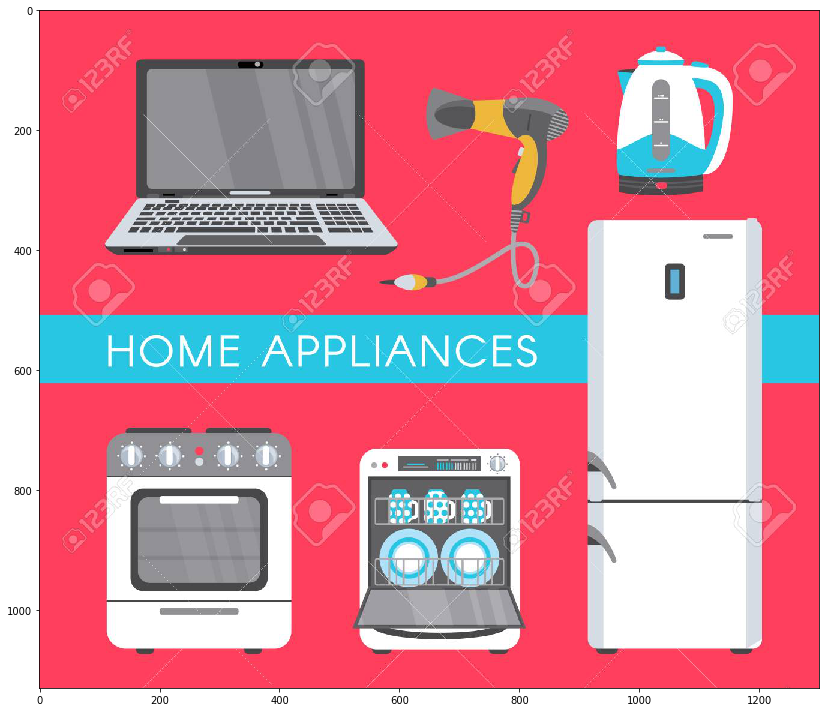

In [9]:
# Load a random image from the images folder
image = skimage.io.imread('sample.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

In [10]:
# Run detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (1130, 1300, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [11]:
# Visualize results
r = results[0]

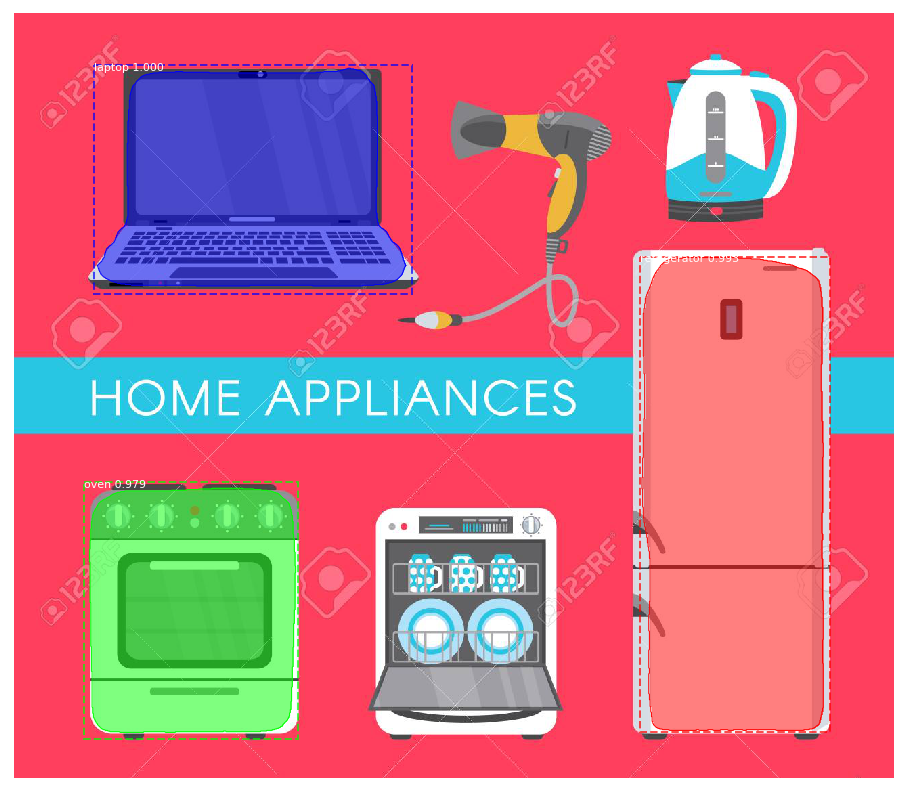

In [12]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [13]:
mask = r['masks']
cls = list(r['class_ids'])
mask = mask.astype(int)
mask.shape

(1130, 1300, 3)

In [14]:
from PIL import Image
import glob

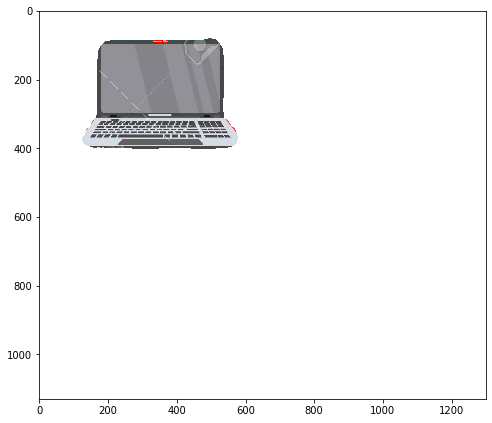

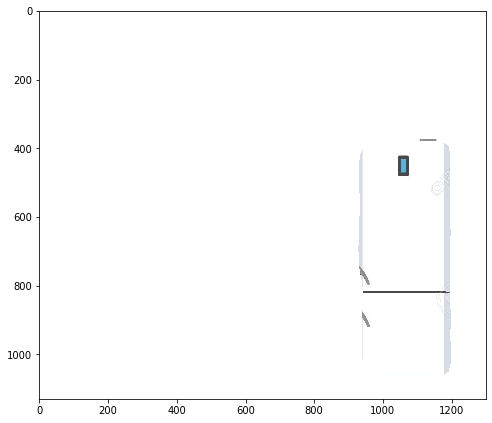

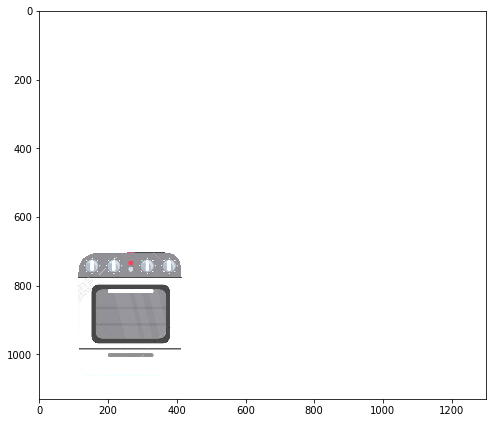

In [15]:
k=0
for i in range(mask.shape[2]):
    temp = skimage.io.imread('sample.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    
    #Set an image name to save the file
    img_name = 'segmented_images/'+class_names[cls[i]]+'_'+str(k)+'.png'
    k+=1
    
    #Convert the black background to a white background
    old_val = 0
    new_val = 255
    temp[temp==old_val]=new_val

    plt.figure(figsize=(8,8))
    plt.imshow(temp)
    plt.imsave(img_name,temp)

### Transparent Image Background

In [16]:
from PIL import Image
import glob

In [17]:
#change path to segmented images as all future work will be in that repo
if os.getcwd().split('/')[-1] != 'segmented_images':
    os.chdir('./segmented_images')

In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Convert white bg to transparent bg
def convert_bg(file):
    img=Image.open(file).convert('RGBA')
    # np.asarray(img) is read only. Wrap it in np.array to make it modifiable.
    arr=np.array(np.asarray(img))
    r,g,b,a=np.rollaxis(arr,axis=-1)
    mask=((r==255)&(g==255)&(b==255))
    arr[mask,3]=0
    img=Image.fromarray(arr,mode='RGBA')
    img.save('./'+file)
    
for file in glob.glob("*.png"):
    convert_bg(file)

In [19]:
os.getcwd()

'/home/sharan/Desktop/Personal Projects/Mask_RCNN/samples/segmented_images'

### Store the images required by the user into a list (for website later)

In [20]:
imgs = []
for img in glob.glob('*.png'):
    temp = img.split('_')[0]
#     if temp in ['refrigerator','tv']:
    imgs.append(img)

### Auto Crop the images

In [21]:
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    #Bounding box given as a 4-tuple defining the left, upper, right, and lower pixel coordinates.
    #If the image is completely empty, this method returns None.
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

for img in imgs:
    temp = img
    bg = Image.open(img) # The image to be cropped
    new_im = trim(bg)
    new_im.save(temp)

### Merge the Images


In [26]:
import sys
from PIL import Image

images = [Image.open(x) for x in imgs]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths) + (len(imgs)*20)
max_height = max(heights)+80

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 20

for i,im in enumerate(images):
    y_offset = max_height//2 - heights[i]//2
    new_im.paste(im, (x_offset,y_offset))
    x_offset += im.size[0]+20

new_im.save('./merged.png')

In [27]:
img=Image.open('./merged.png').convert('RGBA')
# np.asarray(img) is read only. Wrap it in np.array to make it modifiable.
arr=np.array(np.asarray(img))
r,g,b,a=np.rollaxis(arr,axis=-1)
mask=((r==0)&(g==0)&(b==0))
arr[mask,3]=0
img=Image.fromarray(arr,mode='RGBA')
img.save('./merged_transparent.png')

### Apply gradient background

In [74]:
from PIL import Image

import numpy as np

img = Image.open("merged_transparent.png")

background = Image.open("background.jpeg")

# resize the image
size = img.size
background = background.resize(size,Image.ANTIALIAS)

background.paste(img, (0, 0), img)
background.save('final.png',"PNG")

In [75]:
from PIL import Image,ImageDraw,ImageFont
def process_img(img_src, title):

    img = Image.open(img_src, 'r')
    draw = ImageDraw.Draw(img)
    w, h = img.size

    font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf", 50)
    text_w, text_h = draw.textsize(title)

    draw.text(((w - 100) // 2, h - 100), title, (255,255,255),font=font)

    img.save(img_src)

    return img_src

In [76]:
process_img('final.png','Flat 20% OFF!!')

'final.png'